In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from astropy.stats import bootstrap as bootstrap
from statsmodels.tsa.ar_model import AutoReg
import math

In [19]:
# # Mann Kendal Test (Just for checking)
# import pymannkendall as mn

# Mann-kendall test functions

In [20]:
# function for determining tie groups and corresponding number of ties.
def count_ties(x):
    ties = []
    y = x
    while len(x) > 0: 
        ties.append(np.where(x == x[0])[0].size)
        x = np.delete(x, np.where(x == x[0]))
    ties=np.array(ties)
    return ties

In [21]:
#function for calculating variance in mann kendall test
def var(x):
    n = len(x)
    var = n * (n - 1) * (2 * n + 5)
    e = count_ties(x)
    extent_sum = np.sum(e * (e - 1) * (2 * e + 5))
    return  (var - extent_sum)/18

In [22]:
# function for testing pvalue and critical value of mann kendall test
def mktest(z):
    alpha = 0.05    # alpha = 0.05 
    CritVal = np.abs(ss.norm.ppf(alpha / 2))
    pvalue = ss.norm.sf(np.abs(z)) * 2 
    print('pvalue:',pvalue)
# Reject H0 if |Z-Score| > CritVal and, equivalently, if p-value < alpha/2
    reject1 = CritVal < np.abs(z)
    reject2 = pvalue < alpha
    if reject1:
        return 'Yes'
    return 'No'

# Functions for transformation

In [23]:
# Function to find moments of data
def findMoments(data):
    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data, bias=False)

    return xbar, std, skew

# Function to fit data to a normal distribution, using either MLE or MOM
def fitNormal(data, method):
    assert method == 'MLE' or method == 'MOM', "method must = 'MLE' or 'MOM'"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        mu, sigma = ss.norm.fit(data)

    elif method == 'MOM':
        mu = xbar
        sigma = std

    return mu, sigma

# Function to make QQ plot for normal data with correlation test
def NormalPPCT(data, mu, sigma, title, figname):
    x_sorted = np.sort(data)
    p_observed = np.arange(1, len(data) + 1, 1) / (len(data) + 1)
    x_fitted = ss.norm.ppf(p_observed, mu, sigma)
    rho = np.corrcoef(x_sorted, x_fitted)[0, 1]

    plt.scatter(x_sorted, x_fitted, color='b')
    plt.plot(x_sorted, x_sorted, color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.savefig(figname)
    plt.show()

    # Estimate p-value of corelation coefficient
    rhoVector = np.zeros(10000)
    for i in range(10000):
        x = ss.norm.rvs(mu, sigma, len(data))
        rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0, 1]

    count = 0
    for i in range(len(rhoVector)):
        if rho < rhoVector[i]:
            count = count + 1

    p_value = 1 - count / 10000

    return rho, p_value

# Data visualization


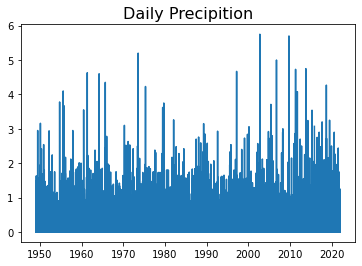

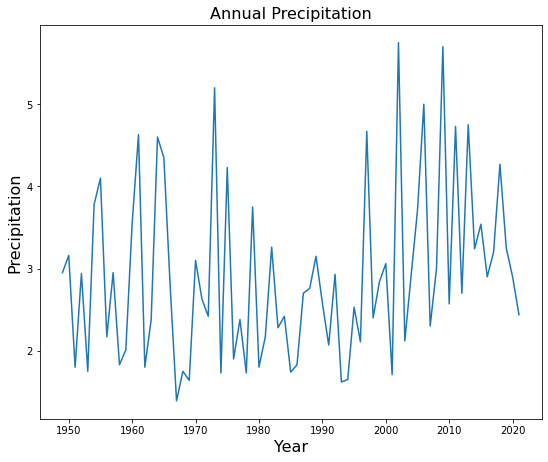

In [24]:
Data = pd.read_csv('precip.csv')
# flow rate unit is CFS

# Make date strings into datetime format so we can calculate dates
Data['datetime'] = pd.to_datetime(Data['datetime'])

# find year of each data point
Data['Year'] = Data['datetime'].dt.year

plt.plot(Data['datetime'], Data['flowrate'])
plt.title('Daily Precipition', fontsize=16)
plt.show()

# find the annual maxima in each year
maxQYear = Data.groupby('Year').max()
# Get just the flow vector for annual maxima as numpy array
maxQ = np.array(maxQYear['flowrate'])
# Get just the year vector for annual maxima as numpy array
fig = plt.figure()
yearMaxQ = np.array(maxQYear['datetime'].dt.year)
plt.plot(yearMaxQ, maxQ)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Precipitation', fontsize=16)
plt.title('Annual Precipitation', fontsize=16)
fig.set_size_inches([9, 7.25])
fig.savefig('Annual Precipitation', dpi=300)
plt.show()


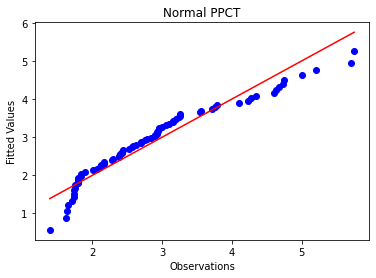

Correlation coefficient:, 0.9631657227683464 
 P-value of Correlation coefficient: 0.0016000000000000458


In [25]:
# test if data is normally distributed
mu, sigma = fitNormal(maxQ,'MOM')
x_sorted = np.sort(maxQ)
rho_norm, p_value_norm = NormalPPCT(maxQ, mu, sigma, 'Normal PPCT', 'NormalPPCT.png')
print('Correlation coefficient:,',rho_norm,'\n','P-value of Correlation coefficient:',p_value_norm)


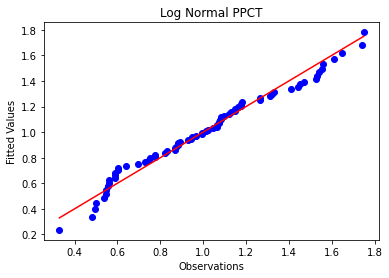

0.989590871288297 0.26259999999999994


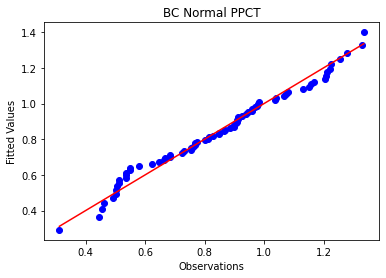

0.9913217408854962 0.35919999999999996


In [26]:
# log transformation?
mu, sigma = fitNormal(np.log(maxQ),'MOM')
rho_log, p_value_log = NormalPPCT(np.log(maxQ), mu, sigma, 'Log Normal PPCT', 'LogNormalPPCT.png')
print(rho_log, p_value_log)

# # Box Cox transformation
# Q_T, llambda = ss.boxcox(maxQ)
# mu, sigma = fitNormal(Q_T,'MOM')
# rho_bc, p_value_bc = NormalPPCT(Q_T, mu, sigma, 'BC Normal PPCT', 'BCNormalPPCT.png')
# print(rho_bc, p_value_bc)


# Testing for autocorrelation

From this point onwards, we use transformed data for our analysis. From previous problem, variable, Q_T is the transformed data.

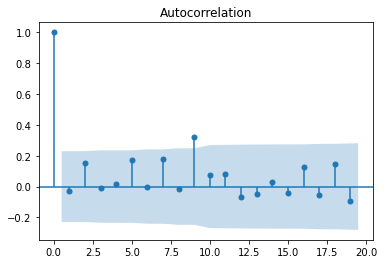

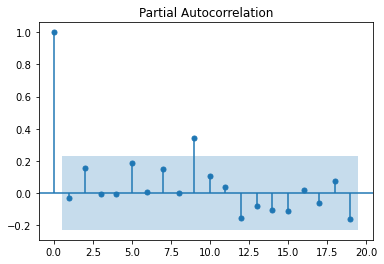

In [27]:
#Plotting ACF and PACF
sm.graphics.tsa.plot_acf(Q_T)
plt.show()
sm.graphics.tsa.plot_pacf(Q_T)
plt.show()

P-values of autoregression coefficients in different lags:
[5.72328889e-17 7.95296354e-01]
[3.60398734e-07 8.12353389e-01 1.98880162e-01]
[1.32681472e-05 8.73449724e-01 1.83191080e-01 9.69476653e-01]
[1.22672051e-04 8.95125275e-01 1.92258158e-01 9.60962693e-01
 9.61135405e-01]
[0.00353637 0.91418445 0.25840173 0.83123917 0.92652671 0.12449957]
[0.00805457 0.9998072  0.26524131 0.91643372 0.96668099 0.13894252
 0.96339707]
[0.03615204 0.88569973 0.28661228 0.91993969 0.7990704  0.20913424
 0.96035573 0.23341407]
[0.04633251 0.97047879 0.2611742  0.83296493 0.79743764 0.24885356
 0.95117752 0.2248011  0.97698089]
[0.23610194 0.94306515 0.47438776 0.80946266 0.92501956 0.20034685
 0.83617332 0.3162614  0.82583395 0.00568787]
[0.34217729 0.70443254 0.5396962  0.85103453 0.98939073 0.32908962
 0.77309687 0.34659003 0.83997963 0.00361074 0.33196111]
[0.41571619 0.51125194 0.7019351  0.76560851 0.84144903 0.2469011
 0.98931921 0.30426919 0.90818874 0.00272763 0.23237205 0.54928295]
[0.3374533

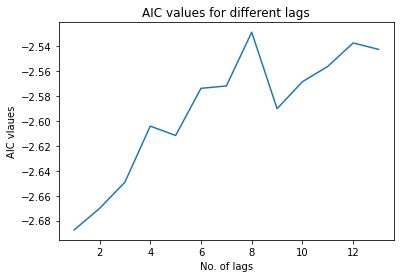

In [28]:
# Finding out AIC values for Autoregression models of different lags
m = []
aic_=np.zeros(13)
print('P-values of autoregression coefficients in different lags:')
for i in range(1,14):
    m.append(i)
    fit1 = (AutoReg(Q_T, lags = m, old_names = True)).fit()
    print(fit1.pvalues)
    fit = (AutoReg(Q_T, lags = m, old_names = True)).fit().aic
    aic_[i-1] = fit
print('AIC values for 1 to 13 lags:',aic_)
plt.plot(m, aic_)
plt.title('AIC values for different lags')
plt.xlabel('No. of lags')
plt.ylabel('AIC vlaues')
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   73
Model:                     AutoReg(1)   Log Likelihood                  -2.414
Method:               Conditional MLE   S.D. of innovations              0.250
Date:                Thu, 24 Feb 2022   AIC                             -2.688
Time:                        11:33:25   BIC                             -2.593
Sample:                             1   HQIC                            -2.650
                                   73                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8707      0.104      8.371      0.000       0.667       1.075
y.L1          -0.0306      0.118     -0.259      0.795      -0.261       0.200
                                    Roots           

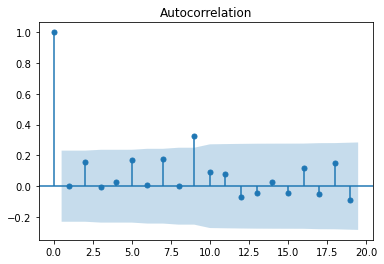

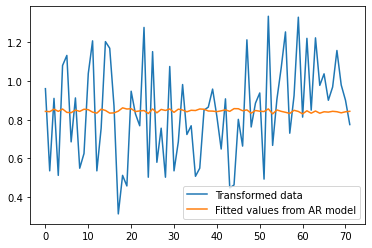

Model parameters and corresponding pvalues for AR1 model:
Model parameters:
[ 0.87071312 -0.03056303]
P-values of model parameters:
[5.72328889e-17 7.95296354e-01]


In [29]:
# Model parameters and corresponding pvalues for AR1 model

fit = AutoReg(Q_T, lags = 1 ,old_names = False).fit()
print(fit.summary())
sm.graphics.tsa.plot_acf(fit.resid)
plt.show()
plt.plot(Q_T[1::], label ='Transformed data')
plt.plot(fit.fittedvalues, label ='Fitted values from AR model')
plt.legend()

plt.show()

print('Model parameters and corresponding pvalues for AR1 model:')
print('Model parameters:')
print(fit.params)
print('P-values of model parameters:')
print(fit.pvalues)


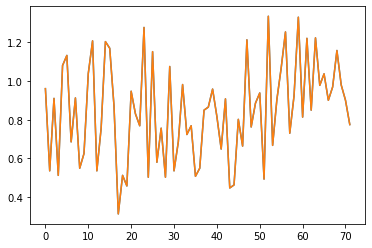

In [30]:
# Checking if the sum of fitted values and residuals give the transformed data
plt.plot(Q_T[1::])
plt.plot( fit.fittedvalues + fit.resid)
plt.show()

Here, we use the residuals from AR model to test for the trend. 

# Testing trend from regression:

In [31]:
# %% test for trend
fitted = pd.DataFrame(fit.resid,columns =['residuals'])
fitted['Year'] = yearMaxQ[1:]

mod = smf.ols(formula='residuals~ Year', data=fitted)
results = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.463
Date:                Thu, 24 Feb 2022   Prob (F-statistic):             0.0382
Time:                        11:33:25   Log-Likelihood:               -0.18869
No. Observations:                  72   AIC:                             4.377
Df Residuals:                      70   BIC:                             8.931
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8521      2.770     -2.112      0.0

# Mann Kendall test

In [32]:
T = 0
data = (fitted['residuals']).to_numpy()
for j in range(len(data)-1):
    t = data[j] - (data[j+1:])
    T += (np.where(t < 0))[0].size - (np.where(t > 0))[0].size
variance = var(data)
if T > 0:
    z = (T - 1)/(np.sqrt(variance))
else:
    z = (T + 1)/(np.sqrt(variance))
print('Z_value:',z)
trend = mktest(z)
print('Is there a monotonic trend?',trend,'\n')


Z_value: 2.0951974938050766
pvalue: 0.03615343997857271
Is there a monotonic trend? Yes 



In [33]:

# nSamples = 10000
# p_values = np.ones(len(Q_T) - 1)

# # If we're not sure where the change point might be, loop over the time series and test every possible time period
# for i in range(len(Q_T) - 1):

   
#     x = bootstrap(np.array(Q_T[:(i + 1)]), nSamples) # Before the change point
#     y = bootstrap(np.array(Q_T[(i + 1):]), nSamples) # After the change point

#     # Compute S, or the number of samples for which the median of X is greater than the median of Y
#     S = 0
#     for j in range(nSamples):
#         if np.median(x[j, :]) > np.median(y[j, :]):   
#             S += 1

#     # Average S over nSamples
#     p_values[i] = S / nSamples

# # Plot p-values of each potential change point
# plt.plot(p_values[0:-1], label ='Pvalues for different times')
# plt.plot([0, len(Q_T)], [0.05, 0.05], label ='Alpha/2')
# plt.legend()
# plt.show()

In [34]:
# Q11 =minQ['Flow'].to_numpy()
# nSamples = 10000
# p_values = np.ones(len(Q11) - 1)

# # If we're not sure where the change point might be, loop over the time series and test every possible time period
# for i in range(len(Q11) - 1):

#     # For each potential time of change point,
#     # bootstrap nSamples from the time before and after the potential change point
#     x = bootstrap(np.array(Q11[:(i + 1)]), nSamples) # Before the change point
#     y = bootstrap(np.array(Q11[(i + 1):]), nSamples) # After the change point

#     # Compute S, or the number of samples for which the mean of X is greater than the mean of Y
#     S = 0
#     for j in range(nSamples):
#         if np.median(x[j, :]) > np.median(y[j, :]):    # This uses mean; could use any other statistic
#             S += 1

#     # Average S over nSamples
#     p_values[i] = S / nSamples

# # Plot p-values of each potential change point
# plt.plot(p_values[0:-1])
# # Plot alpha/2 as threshold for statistical significance (use 1-alpha/2 if necessary)
# plt.plot([0, len(Q11)], [0.05, 0.05])
# plt.show()